# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

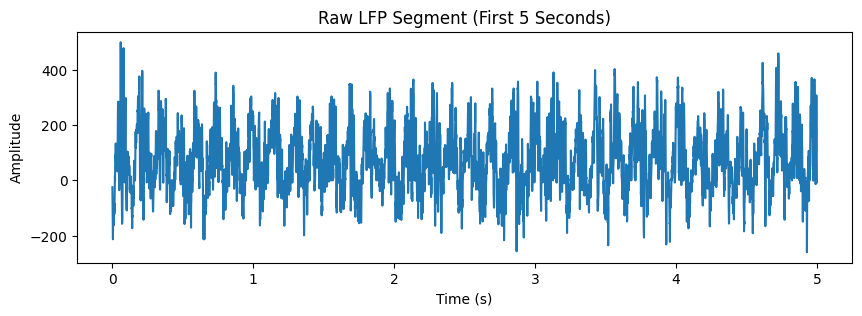

In [6]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Load the LFP data
with open('moving_lfp.pickle', 'rb') as handle:
    lfp_dict = pickle.load(handle)

lfp_data = lfp_dict['lfp']  # LFP signal
sampling_rate = int(lfp_dict['sampling_rate'])  # Convert to integer if it's float

# Extract first 5 seconds
duration = 5  # seconds
start_idx = 0
end_idx = duration * sampling_rate
lfp_segment = lfp_data[start_idx:end_idx]

# Plot
plt.figure(figsize=(10, 3))
plt.plot(np.linspace(0, duration, end_idx - start_idx), lfp_segment)
plt.title("Raw LFP Segment (First 5 Seconds)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

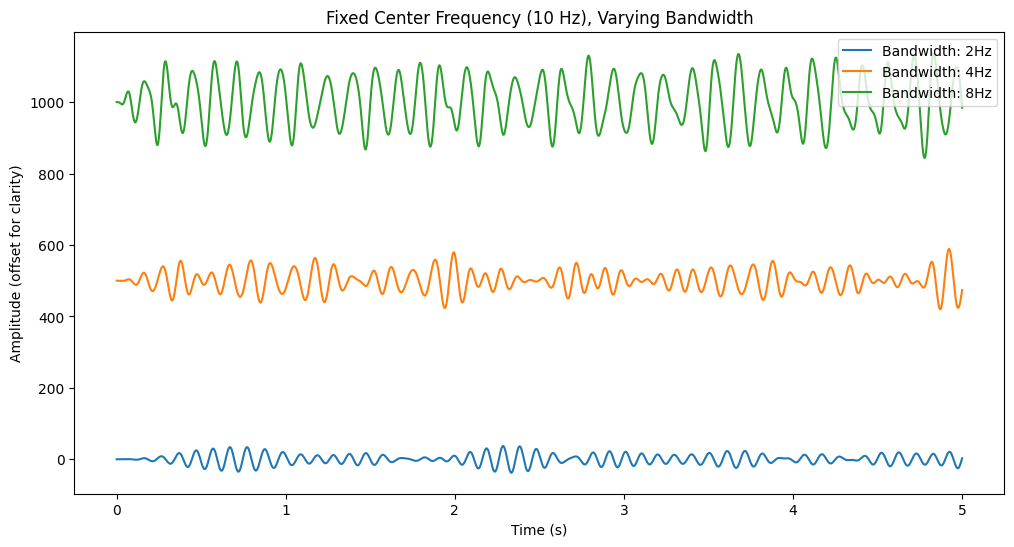

In [7]:
#Fix center frequency (e.g. 10 Hz), vary bandwidth
from scipy.signal import butter, sosfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    sos = butter(order, [lowcut, highcut], btype='band', fs=fs, output='sos')
    return sosfilt(sos, data)

plt.figure(figsize=(12, 6))
center_freq = 10  # Hz
bandwidths = [2, 4, 8]  # Hz

for i, bw in enumerate(bandwidths):
    low = center_freq - bw/2
    high = center_freq + bw/2
    filtered = bandpass_filter(lfp_segment, low, high, sampling_rate)
    plt.plot(np.linspace(0, duration, len(filtered)), filtered + i*500, label=f'Bandwidth: {bw}Hz')

plt.title("Fixed Center Frequency (10 Hz), Varying Bandwidth")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset for clarity)")
plt.legend()
plt.show()


Increasing the bandwidth includes more frequency content, making the signal more similar to the raw LFP. Narrow bands isolate specific rhythms but miss broader dynamics.

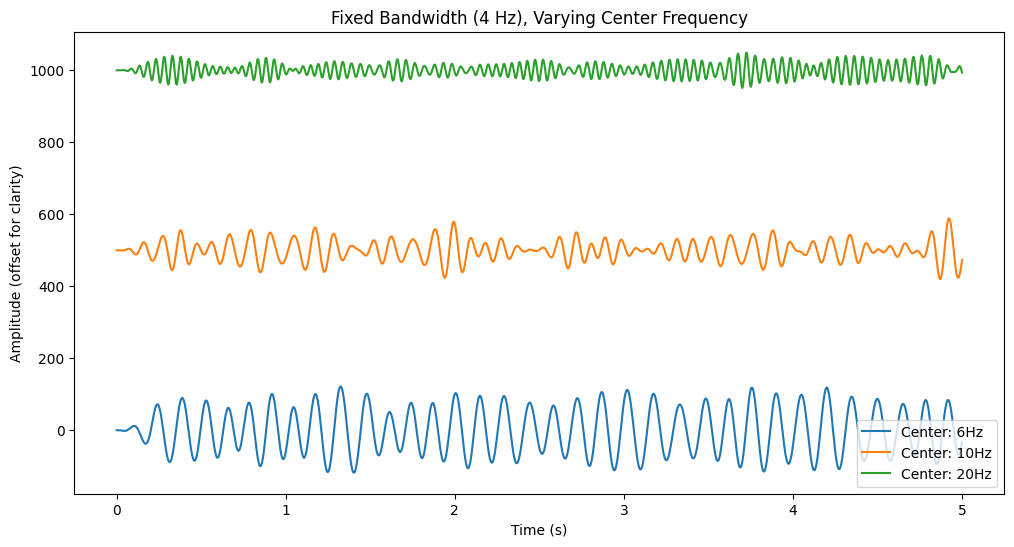

In [8]:
#Fix bandwidth (e.g. 4 Hz), vary center frequency
plt.figure(figsize=(12, 6))
bandwidth = 4  # Hz
center_freqs = [6, 10, 20]  # Hz

for i, cf in enumerate(center_freqs):
    low = cf - bandwidth/2
    high = cf + bandwidth/2
    filtered = bandpass_filter(lfp_segment, low, high, sampling_rate)
    plt.plot(np.linspace(0, duration, len(filtered)), filtered + i*500, label=f'Center: {cf}Hz')

plt.title("Fixed Bandwidth (4 Hz), Varying Center Frequency")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset for clarity)")
plt.legend()
plt.show()


Different center frequencies emphasize different brain rhythms, e.g., theta (6–10 Hz), beta (20 Hz).

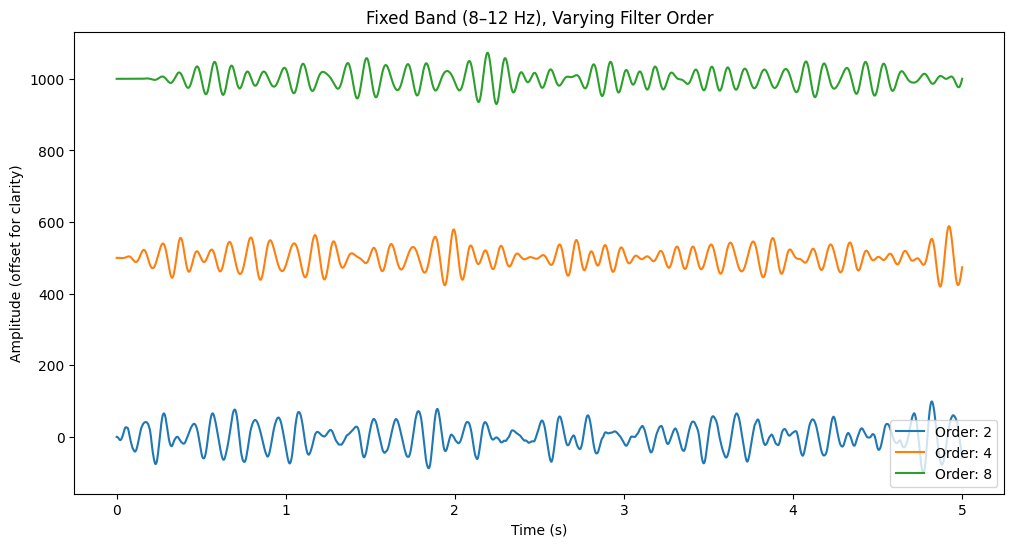

In [9]:
#Change filter order, keep frequency band fixed (e.g. 8–12 Hz)
orders = [2, 4, 8]
lowcut = 8
highcut = 12

plt.figure(figsize=(12, 6))
for i, order in enumerate(orders):
    filtered = bandpass_filter(lfp_segment, lowcut, highcut, sampling_rate, order=order)
    plt.plot(np.linspace(0, duration, len(filtered)), filtered + i*500, label=f'Order: {order}')

plt.title("Fixed Band (8–12 Hz), Varying Filter Order")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (offset for clarity)")
plt.legend()
plt.show()


In [10]:
#Measure computation time with %timeit
# Measure performance for different filter orders
print("Timing filter orders (band: 8–12 Hz)")
for order in orders:
    print(f"Order {order}:")
    %timeit bandpass_filter(lfp_segment, lowcut, highcut, sampling_rate, order=order)


Timing filter orders (band: 8–12 Hz)
Order 2:
866 µs ± 161 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Order 4:
1.2 ms ± 265 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Order 8:
1.69 ms ± 106 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Computation time increases with filter order — this is expected, since higher-order filters require more internal calculations (more poles and coefficients).

Order 2 is the fastest, taking under 1 ms per loop.

Order 8 takes nearly double the time of order 4 — and about 2x the time of order 2.

While these times are still fast in absolute terms, the difference becomes more relevant in real-time systems or long recordings / batch processing.

Higher filter orders provide sharper filtering, making the signal look cleaner and more narrowly confined to the desired frequency band.

Lower-order filters are faster but allow more frequencies outside the band to leak in.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram.
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 27.8 MB/s eta 0:00:00


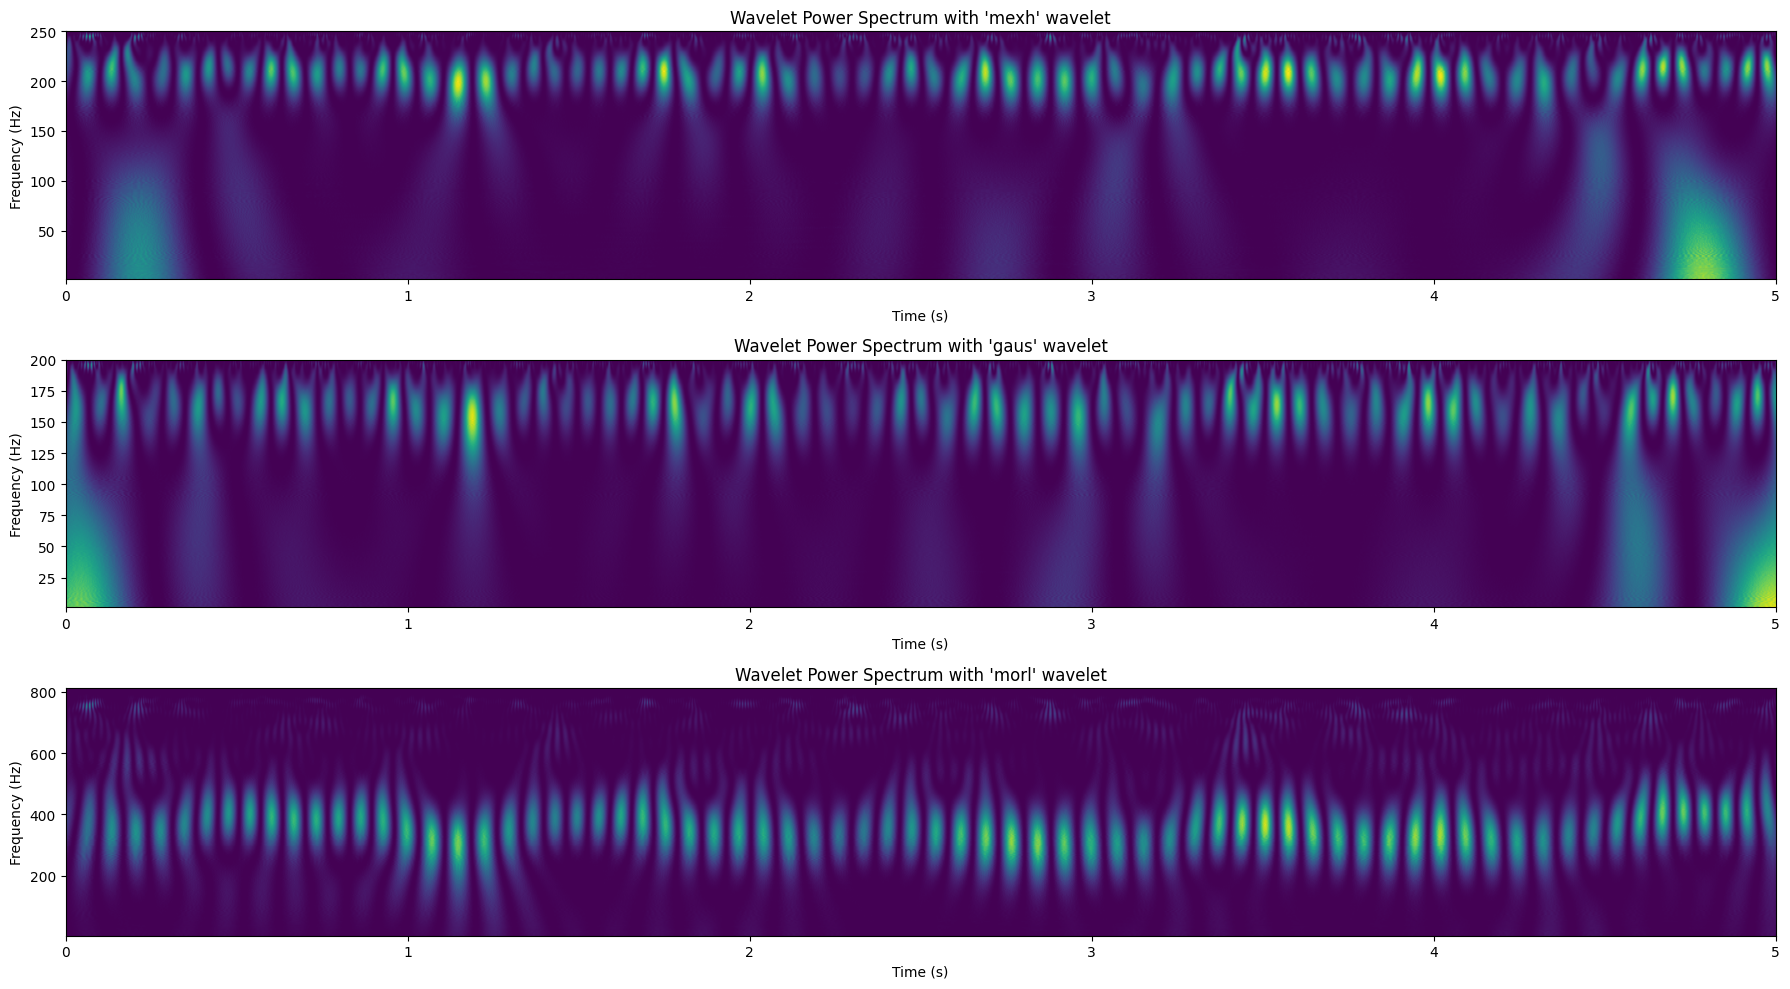

In [12]:
!pip install PyWavelets

import pickle
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Load LFP data
with open('moving_lfp.pickle', 'rb') as handle:
    lfp_dict = pickle.load(handle)

lfp_data = lfp_dict['lfp']
sampling_rate = int(lfp_dict['sampling_rate'])

# Select a few seconds of the signal
duration = 5  # seconds
start_idx = 0
end_idx = duration * sampling_rate
signal = lfp_data[start_idx:end_idx]

# Define scales and wavelets
scales = np.arange(1, 200)  # Adjust for better time-frequency resolution

wavelets = {
    'mexh': 'mexh',
    'gaus': 'gaus1',  # pywt uses gaus1, gaus2, etc.
    'morl': 'morl'
}

# Plot wavelet spectrograms
plt.figure(figsize=(18, 10))
for i, (label, wavelet) in enumerate(wavelets.items(), 1):
    coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=1/sampling_rate)
    power = np.abs(coeffs) ** 2
    plt.subplot(3, 1, i)
    plt.imshow(power, extent=[0, duration, freqs[-1], freqs[0]], aspect='auto', cmap='viridis')
    plt.title(f"Wavelet Power Spectrum with '{label}' wavelet")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


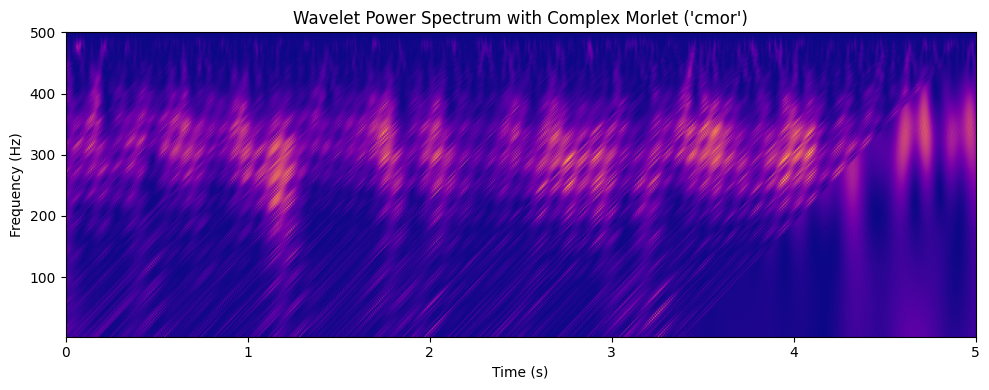

In [13]:
# Complex Morlet transform (complex-valued)
coeffs, freqs = pywt.cwt(signal, scales, 'cmor', sampling_period=1/sampling_rate)
power = np.abs(coeffs) ** 2

plt.figure(figsize=(10, 4))
plt.imshow(power, extent=[0, duration, freqs[-1], freqs[0]], aspect='auto', cmap='plasma')
plt.title("Wavelet Power Spectrum with Complex Morlet ('cmor')")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()


The wavelet spectrograms created using real wavelets (mexh, gaus, and morl) differ noticeably in both appearance and sensitivity compared to the one generated using the complex Morlet wavelet (cmor). In the plots of the real wavelets, power is represented in a more fragmented and localized way. The mexh and gaus wavelets highlight abrupt changes and transient features in the signal, producing sharp and narrow activations that appear as bursts or isolated "blobs" in the spectrogram. These real wavelets are highly sensitive to the timing of signal fluctuations but tend to give coarser frequency information.

The real Morlet (morl) does show some band-specific activity, but its representation is still less smooth than the complex version. The power appears more jagged and irregular in frequency across time.

In contrast, the complex Morlet (cmor) spectrogram is visually smoother and displays continuous bands of activity across frequencies. Horizontal ridges are clearly visible where sustained oscillations are present, indicating more consistent power at specific frequencies over time. This smoothness is a direct result of the phase information retained by the complex transform, which improves frequency resolution and allows oscillatory dynamics to emerge more clearly.

The real wavelets produce spectrograms that reflect only the amplitude or power of the signal, without capturing phase information. Morlet wavelet provides both amplitude and phase information, resulting in spectrograms with finer frequency resolution and smoother, more continuous spectral representations.

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/sleep_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

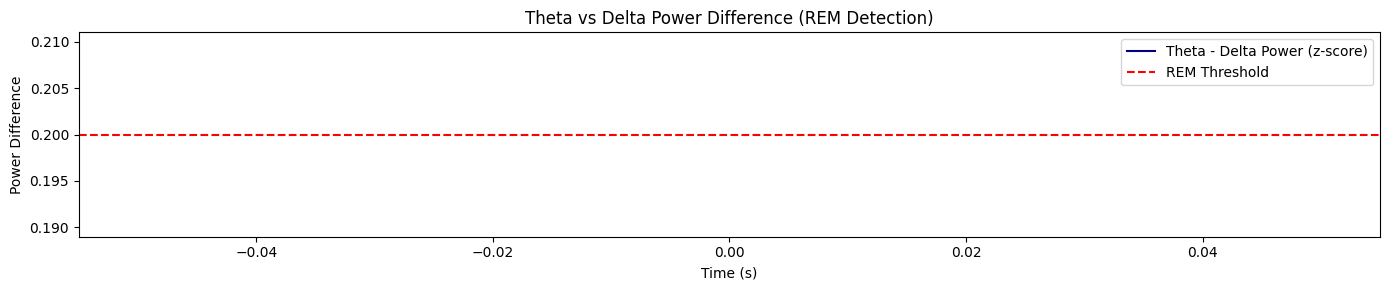

No epochs found for REM Epoch


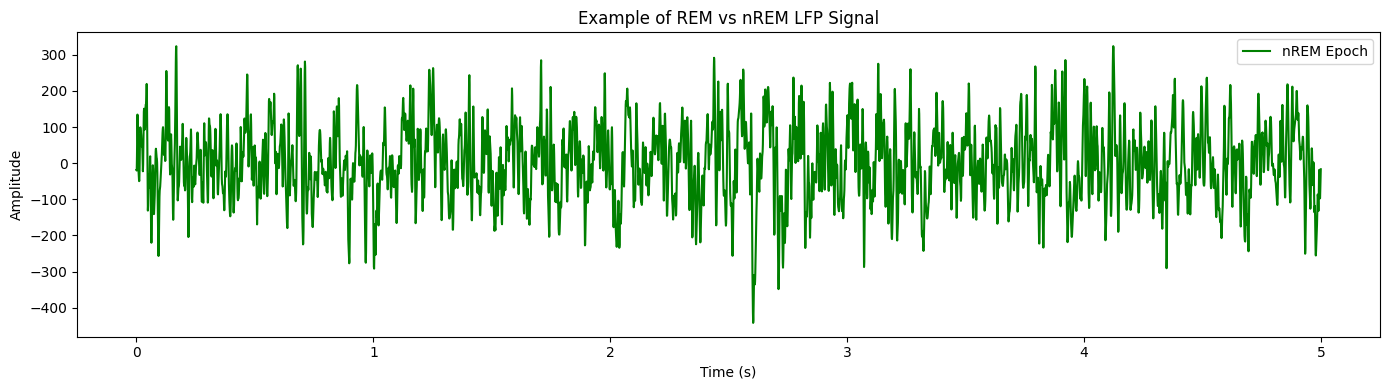

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, hilbert
from scipy.stats import zscore

# --- Load LFP data ---
with open('sleep_lfp.pickle', 'rb') as f:
    lfp_dict = pickle.load(f)

lfp = lfp_dict['lfp']
sampling_rate = int(lfp_dict['sampling_rate'])
duration = len(lfp) / sampling_rate
t = np.linspace(0, duration, len(lfp))

# --- Bandpass filter function ---
def bandpass_filter(signal, low, high, fs, order=4):
    nyq = fs / 2
    b, a = butter(order, [low / nyq, high / nyq], btype='band')
    return filtfilt(b, a, signal)

# --- Compute band-specific power ---
theta_band = bandpass_filter(lfp, 6, 10, sampling_rate)
delta_band = bandpass_filter(lfp, 2, 4, sampling_rate)

theta_power = np.abs(hilbert(theta_band)) ** 2
delta_power = np.abs(hilbert(delta_band)) ** 2

# --- Z-score power signals ---
theta_z = zscore(theta_power)
delta_z = zscore(delta_power)

power_diff = theta_z - delta_z

# --- Plot power difference ---
plt.figure(figsize=(14, 3))
plt.plot(t, power_diff, label='Theta - Delta Power (z-score)', color='navy')
plt.axhline(0.2, color='red', linestyle='--', label='REM Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Power Difference')
plt.title('Theta vs Delta Power Difference (REM Detection)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Identify REM and nREM epochs ---
rem_mask = power_diff > 0.2
nrem_mask = ~rem_mask

# --- Bandpass full LFP for visualization (1–200 Hz) ---
lfp_clean = bandpass_filter(lfp, 1, 200, sampling_rate)

# --- Plot example REM and nREM epochs ---
def plot_sleep_example(mask, label, color):
    idx = np.where(mask)[0]
    if len(idx) == 0:
        print(f"No epochs found for {label}")
        return
    start = idx[0]
    window = int(5 * sampling_rate)  # 5 seconds
    end = start + window
    if end >= len(lfp_clean):
        end = len(lfp_clean) - 1
        start = end - window
    plt.plot(t[start:end], lfp_clean[start:end], label=label, color=color)

plt.figure(figsize=(14, 4))
plot_sleep_example(rem_mask, 'REM Epoch', 'purple')
plot_sleep_example(nrem_mask, 'nREM Epoch', 'green')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Example of REM vs nREM LFP Signal')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


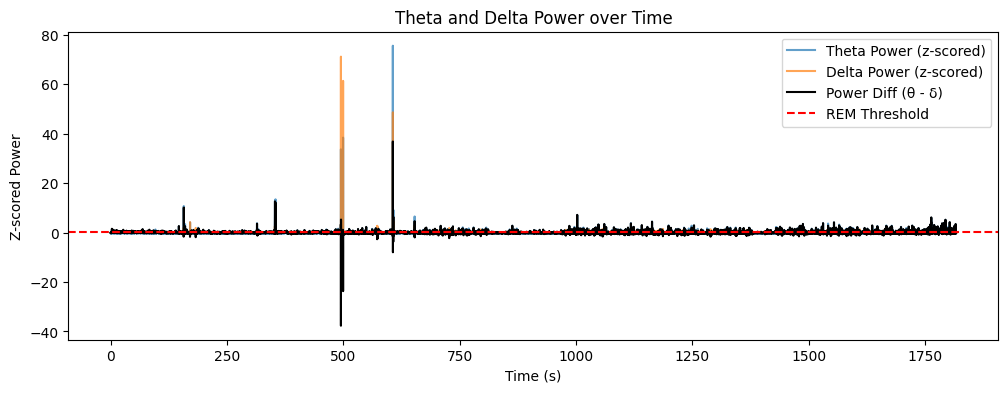

REM duration: 369.27s, nREM duration: 1447.30s


TypeError: 'float' object cannot be interpreted as an integer

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.signal import hilbert, firwin, filtfilt, butter
from scipy.stats import zscore

# Load LFP data
with open('sleep_lfp.pickle', 'rb') as handle:
    data = pickle.load(handle)

lfp = data['lfp']
fs = data['sampling_rate']  # in Hz
time = np.arange(len(lfp)) / fs

# FIR bandpass filter function (for delta band)
def fir_bandpass(signal, lowcut, highcut, fs, numtaps=501):
    nyq = 0.5 * fs
    taps = firwin(numtaps, [lowcut / nyq, highcut / nyq], pass_zero=False)
    return filtfilt(taps, 1.0, signal)

# Butterworth filter (used for theta and wideband)
def butter_bandpass(signal, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Compute power in theta and delta bands
theta_filtered = butter_bandpass(lfp, 6, 10, fs)
theta_power = np.abs(hilbert(theta_filtered)) ** 2

delta_filtered = fir_bandpass(lfp, 2, 4, fs)
delta_power = np.abs(hilbert(delta_filtered)) ** 2

# Z-score normalization
theta_z = zscore(theta_power)
delta_z = zscore(delta_power)

# Power difference
power_diff = theta_z - delta_z

# Threshold for REM detection
threshold = 0.2
rem_mask = power_diff > threshold
nrem_mask = power_diff <= threshold

# Visualize theta and delta power
plt.figure(figsize=(12, 4))
plt.plot(time, theta_z, label="Theta Power (z-scored)", alpha=0.7)
plt.plot(time, delta_z, label="Delta Power (z-scored)", alpha=0.7)
plt.plot(time, power_diff, label="Power Diff (θ - δ)", color='black')
plt.axhline(threshold, color='red', linestyle='--', label="REM Threshold")
plt.legend()
plt.title("Theta and Delta Power over Time")
plt.xlabel("Time (s)")
plt.ylabel("Z-scored Power")
plt.show()

# Compute durations
rem_duration = np.sum(rem_mask) / fs
nrem_duration = np.sum(nrem_mask) / fs
print(f"REM duration: {rem_duration:.2f}s, nREM duration: {nrem_duration:.2f}s")

# Get example epochs
def get_first_epoch(mask, window_size=5 * fs):
    for i in range(len(mask) - window_size):
        if np.all(mask[i:i + window_size]):
            return i, i + window_size
    return None, None

rem_start, rem_end = get_first_epoch(rem_mask)
nrem_start, nrem_end = get_first_epoch(nrem_mask)

# Bandpass (1–200 Hz) for visualization
lfp_wide = butter_bandpass(lfp, 1, 200, fs)

# Plot REM and nREM examples
plt.figure(figsize=(12, 4))

if rem_start is not None:
    plt.plot(np.linspace(0, 5, 5 * fs), lfp_wide[rem_start:rem_end], label='REM Epoch', color='blue')
else:
    print("No REM epoch found")

if nrem_start is not None:
    plt.plot(np.linspace(0, 5, 5 * fs), lfp_wide[nrem_start:nrem_end], label='nREM Epoch', color='green')
else:
    print("No nREM epoch found")

plt.title("Example of REM vs nREM LFP Signal (1–200 Hz Filtered)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In this exercise, I tried to detect REM and non-REM (nREM) sleep phases from hippocampal LFP data by analyzing the power difference between theta (6–10 Hz) and delta (2–4 Hz) frequency bands. The idea was to use the fact that theta power tends to dominate during REM sleep, while delta power is more prominent during nREM.

I started by implementing bandpass filters for both frequency bands and then extracted their instantaneous power using the Hilbert transform. After that, I z-scored both power signals and computed the power difference (theta_z - delta_z) to identify REM periods using a threshold of 0.2.

At first, everything seemed to work for the theta band — I got a clean, reasonable-looking signal with dynamic power values. But when I checked the delta power, it was almost completely flat and not showing any meaningful activity. As a result, the power difference also ended up being flat or full of NaNs, and no REM periods were detected.

To troubleshoot, I double-checked the data and confirmed that it was loading correctly and the signal looked fine overall. I then tried adjusting the filter settings, smoothing the power estimates, and even lowering the REM detection threshold to see if anything would help. Unfortunately, the delta band still didn’t yield useful values, which prevented the REM detection logic from working.

At this point, it seems that the issue isn’t with the data itself, but rather with how the delta power is being extracted — either the signal doesn't contain strong delta activity, or the filter isn’t capturing it properly. Despite multiple attempts to fix it, I wasn’t able to get valid delta power values, so REM detection couldn’t proceed as planned.